In [ ]:
# Note: most of the code in this notebook has been adapted from the code here: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

In [ ]:
import requests
session = requests.session()
session.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'

In [ ]:
# !pip install -q hvplot
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
!pip install -q yfinance

     |████████████████████████████████| 50 kB 4.2 MB/s 
     |████████████████████████████████| 110 kB 13.9 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 112 kB 58.6 MB/s 
     |████████████████████████████████| 128 kB 77.3 MB/s 
     |████████████████████████████████| 4.0 MB 74.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime

# 6. Predicting the closing price stock price of APPLE inc:

In [ ]:
def get_data():
  # Get the stock quote
  df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now(), session = session)
  # Show the data
  return df

In [ ]:
def plot_data(df):
  plt.figure(figsize=(16,6))
  plt.title('Close Price History')
  plt.plot(df['Close'])
  plt.xlabel('Date', fontsize=18)
  plt.ylabel('Close Price USD ($)', fontsize=18)
  plt.show()

In [ ]:
# Columns needs to be a list of strings, such as ['Close', 'Open', 'High', 'Low', 'Volume']
def get_input_columns(df, columns):
  data = df.filter(columns)
  # Convert the dataframe to a numpy array
  dataset = data.values
  # Get the number of rows to train the model on
  training_data_len = int(np.ceil( len(dataset) * .95 ))

  # Number of input features
  num_input_features = len(columns)

  return dataset, training_data_len, num_input_features, data

In [ ]:
def scale_data(dataset):
  # Scale the data
  from sklearn.preprocessing import MinMaxScaler

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)

  return scaled_data

In [ ]:
def create_train_data(scaled_data, training_data_len, num_input_features):
  '''
  Every row of x_train is the past 60 days of closing prices, and y is just a single column of the 61st closing price
  We added opening prices to x_train
  '''

  # Create the training data set 
  # Create the scaled training data set
  train_data = scaled_data[0:int(training_data_len), :]

  # Split the data into x_train and y_train data sets
  x_train = []
  y_train = []

  for i in range(60, len(train_data)):
      x_train.append(train_data[i-60:i, :])
      y_train.append(train_data[i, 0])
  # for i in range(360, len(train_data)):
  #     x_train.append(train_data[i-360:i-300, :])
  #     y_train.append(train_data[i, 0])
          
  # Convert the x_train and y_train to numpy arrays 
  x_train, y_train = np.array(x_train), np.array(y_train)

  # Reshape the data
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_input_features))

  return x_train, y_train

In [ ]:
def build_model(x_train, y_train, num_input_features):
  from keras.models import Sequential
  from keras.layers import Dense, LSTM

  # To look up:
  '''
  epochs
  dense layers
  return_sequences
  optimizer
  input_shape
  '''

  # Look at the input shape for the LSTM model
  print("The input shape is " + str(x_train.shape[1]) + ", " + str(num_input_features))
  print("x_train.shape[1] is: ", x_train.shape[1])
  print("num_input_features is: ", num_input_features)

  from keras.callbacks import EarlyStopping


  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], num_input_features)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

  # Train the model
  # , callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)]
  history = model.fit(x_train, y_train, batch_size=1, epochs=16, validation_split=0.2)

  return model, history

In [ ]:
def test_model(scaled_data, training_data_len, dataset, model, num_input_features, dataframe):
  from sklearn.preprocessing import MinMaxScaler
  # Create the testing data set
  # Create a new array containing scaled values from index 1543 to 2002 
  test_data = scaled_data[training_data_len - 60: , :]
  # test_data = scaled_data[training_data_len - 360: , :]
  # Create the data sets x_test and y_test
  x_test = []
  y_test = dataset[training_data_len:, 0]
  for i in range(60, len(test_data)):
      x_test.append(test_data[i-60:i, 0:])
  # for i in range(360, len(test_data)):
  #     x_test.append(test_data[i-360:i-300, 0:])
      
  # Convert the data to a numpy array
  x_test = np.array(x_test)

  # Reshape the data
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_input_features))

  # Get the models predicted price values 
  predictions = model.predict(x_test)

  scaler_2 = MinMaxScaler(feature_range=(0,1))
  just_closing_prices = dataframe.filter(['Close']).values
  fakeresult = scaler_2.fit_transform(just_closing_prices)
  predictions = scaler_2.inverse_transform(predictions)

  # Get the root mean squared error (RMSE)
  rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
  rmse

  print("y_test shape: ", y_test.shape)
  print("predictions shape: ", predictions.shape)

  print("----------------------------------------------------------------------")
  print("predictions here:")
  print(predictions)
  print("----------------------------------------------------------------------")

  return predictions, rmse

In [ ]:
def plot_predictions(data, training_data_len, predictions, xlabel = 'Date', ylabel = 'Close Price USD ($)'):
  # Plot the data
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid['Predictions'] = predictions
  # Visualize the data
  plt.figure(figsize=(16,6))
  plt.title('Model')
  plt.xlabel(xlabel, fontsize=18)
  plt.ylabel(ylabel, fontsize=18)
  plt.plot(train['Close'])
  plt.plot(valid[['Close', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.show()

  return valid

In [ ]:
# Put everything inside a single function

def run_lstm_yfinance(columns):
  df = get_data()
  # plot_data(df)
  dataset, training_data_len, num_input_features, data = get_input_columns(df, columns)
  scaled_data = scale_data(dataset)
  x_train, y_train = create_train_data(scaled_data, training_data_len, num_input_features)
  model, history = build_model(x_train, y_train, num_input_features)
  predictions, rmse = test_model(scaled_data, training_data_len, dataset, model, num_input_features, df)
  valid = plot_predictions(data, training_data_len, predictions)
  return valid, rmse


In [ ]:
# Run the entire function
columns_1 = ['Close', 'Open', 'High', 'Low', 'Volume']
columns_2 = ['Close']
# valid, rmse = run_lstm_yfinance(columns_1)
# print("----------------------------------------------------------------------")
# print("valid: ")
# print(valid)
# print("----------------------------------------------------------------------")
# print("rmse: ")
# print(rmse)

In [ ]:
# We have a general function for the data from yfinance.
# Now let's try to make a similar function for local data (aka, our aapl_trade_prices.csv)

def run_lstm_csv(columns):
  # Prepare the csv file

  from google.colab import files
  uploaded = files.upload()

  import io
  df = pd.read_csv(io.BytesIO(uploaded['aapl_trade_prices.csv']))

  # df = pd.read_csv('aapl_trade_prices.csv')
  del df[df.columns[0]]
  # Renaming the columns now just to be lazy... don't get confused, these are still the collection_time and price
  df.rename(columns={'COLLECTION_TIME': 'Date', 'PRICE': 'Close'}, inplace=True)
  df.head()

  # plot_data(df)
  dataset, training_data_len, num_input_features, data = get_input_columns(df, columns)
  scaled_data = scale_data(dataset)
  x_train, y_train = create_train_data(scaled_data, training_data_len, num_input_features)
  model, history = build_model(x_train, y_train, num_input_features)

  # Try to save model
  # model.save('aapl_trades_model')
  # !zip -r /content/sample_data.zip /content/sample_data
  # files.download('/content/sample_data.zip')

  predictions, rmse = test_model(scaled_data, training_data_len, dataset, model, num_input_features, df)
  valid = plot_predictions(data, training_data_len, predictions, "COLLECTION_TIME", "PRICE")
  return valid, rmse

In [ ]:
# Now let's try running run_lstm_csv

columns_1 = ['Close']
# valid, rmse = run_lstm_csv(columns_1)

# Let's rename the validation since I was too lazy to change 'Close' in all of the functions earlier:
# valid.rename(columns={'Close': 'PRICE'}, inplace=True)

# print("----------------------------------------------------------------------")
# print("valid: ")
# print(valid)
# print("----------------------------------------------------------------------")
# print("rmse: ")
# print(rmse)

In [ ]:
# from google.colab import files
# files.download('/content/aapl_trades_model/keras_metadata.pb')
# files.download('/content/aapl_trades_model/saved_model.pb')

In [ ]:
# !zip -r /content/aapl_trades_model.zip /content/aapl_trades_model
# files.download('/content/aapl_trades_model.zip')

In [ ]:
# Take a look at combined_data.csv
# from google.colab import files
# uploaded = files.upload()

# import pandas as pd

# import io
# df = pd.read_csv(io.BytesIO(uploaded['combined_data.csv']))
# df.head()

In [ ]:
# This function is similar to run_lstm_csv, but is catered for combined_data.csv

def run_lstm_combined(columns):
  # Prepare the csv file
  from google.colab import files
  uploaded = files.upload()

  import io
  df = pd.read_csv(io.BytesIO(uploaded['combined_data.csv']))

  del df[df.columns[0]]
  # Renaming the columns now just to be lazy... don't get confused, these are still the collection_time and price
  df.rename(columns={'binned': 'Date', 'AVG(PRICE)': 'Close'}, inplace=True)
  df.head()

  # plot_data(df)
  dataset, training_data_len, num_input_features, data = get_input_columns(df, columns)
  scaled_data = scale_data(dataset)
  x_train, y_train = create_train_data(scaled_data, training_data_len, num_input_features)
  model, history = build_model(x_train, y_train, num_input_features)

  # Try to save model
  model.save('combined_data_model', save_format='h5', include_optimizer=False)

  predictions, rmse = test_model(scaled_data, training_data_len, dataset, model, num_input_features, df)
  valid = plot_predictions(data, training_data_len, predictions, "binned", "AVG(PRICE)")
  return valid, rmse, history

Saving combined_data.csv to combined_data.csv
The input shape is 60, 4
x_train.shape[1] is:  60
num_input_features is:  4
Epoch 1/16
2774/2774 [==============================] - 106s 36ms/step - loss: 0.0018 - accuracy: 7.2098e-04 - val_loss: 3.6371e-04 - val_accuracy: 0.0000e+00
Epoch 2/16
2774/2774 [==============================] - 97s 35ms/step - loss: 6.6423e-04 - accuracy: 7.2098e-04 - val_loss: 1.9708e-04 - val_accuracy: 0.0000e+00
Epoch 3/16
2774/2774 [==============================] - 96s 34ms/step - loss: 4.2981e-04 - accuracy: 7.2098e-04 - val_loss: 1.4420e-04 - val_accuracy: 0.0000e+00
Epoch 4/16
2774/2774 [==============================] - 97s 35ms/step - loss: 3.6230e-04 - accuracy: 7.2098e-04 - val_loss: 9.9211e-05 - val_accuracy: 0.0000e+00
Epoch 5/16
2774/2774 [==============================] - 96s 35ms/step - loss: 3.5133e-04 - accuracy: 7.2098e-04 - val_loss: 1.3370e-04 - val_accuracy: 0.0000e+00
Epoch 6/16
2774/2774 [==============================] - 97s 35ms/step -

<ipython-input-15-1cefbd6b2469>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


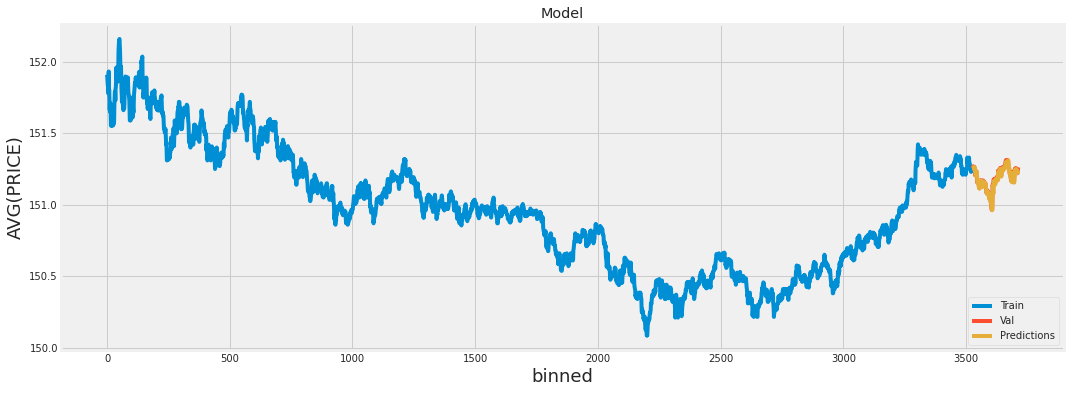

----------------------------------------------------------------------
valid: 
      AVG(PRICE)   AVG(SIZE)  MIN(BID_PRICE_1)  MAX(ASK_PRICE_1)  Predictions
3528  151.260000    6.500000            150.00            151.28   151.253296
3529  151.269000   71.600000            150.00            151.28   151.254852
3530  151.260000    2.000000            151.26            151.28   151.262833
3531  151.265000    7.000000            150.00            151.28   151.261307
3532  151.265000  100.000000            150.00            151.28   151.257080
...          ...         ...               ...               ...          ...
3708  151.240000  137.666667            150.00            151.50   151.232437
3709  151.220000  100.000000            151.21            151.60   151.236420
3710  151.250000  138.000000            150.00            151.60   151.222656
3711  151.250000  200.000000            150.00            151.60   151.241898
3712  151.261667   95.333333            149.98            151.6

In [ ]:
# Run the entire function
columns_1 = ['Close', 'AVG(SIZE)', 'MIN(BID_PRICE_1)', 'MAX(ASK_PRICE_1)']

valid, rmse, history = run_lstm_combined(columns_1)

valid.rename(columns={'Close': 'AVG(PRICE)', }, inplace=True)
print("----------------------------------------------------------------------")
print("valid: ")
print(valid)
print("----------------------------------------------------------------------")
print("rmse: ")
print(rmse)



In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
print("history.history['loss']")
print(history.history['loss'])

print("history.history['val_loss']")
print(history.history['val_loss'])

history.history['loss']
[0.0017992387292906642, 0.0006642277003265917, 0.0004298107814975083, 0.00036230316618457437, 0.0003513269766699523, 0.00034050949034281075, 0.0003154610749334097, 0.0002978455158881843, 0.00025808255304582417, 0.0002723789948504418, 0.0002603415632620454, 0.0002600000298116356, 0.00023780070478096604, 0.00024816120276227593, 0.0002379910583840683, 0.00023339505423791707]
history.history['val_loss']
[0.00036370899761095643, 0.00019708015315700322, 0.00014419597573578358, 9.921057062456384e-05, 0.00013369951921049505, 0.00047824421199038625, 0.00011664502380881459, 0.000271610013442114, 8.309203258249909e-05, 0.0002302639331901446, 0.00011052883928641677, 0.00011792655277531594, 8.00882262410596e-05, 0.00013281266728881747, 8.560265268897638e-05, 9.70627079368569e-05]


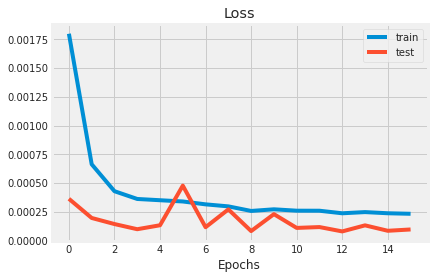

In [ ]:
# Look at plots to test overfitting

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.legend()
plt.show();

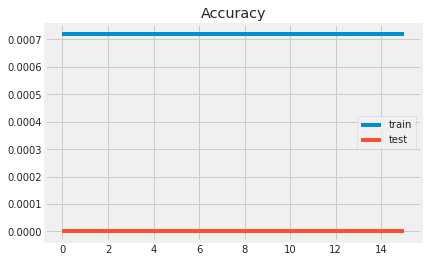

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# Get difference between predictions and actual avg prices in valid

difference = sum(abs(valid['Predictions'] - valid['AVG(PRICE)']))
difference_2 = sum(valid['Predictions'] - valid['AVG(PRICE)'])

print(difference)
print(difference_2)

2.60336302548518
-1.0473027343771264


In [ ]:
# Save the model built from the combined_data.csv
from google.colab import files
!zip -r /content/combined_data_model.zip /content/combined_data_model
files.download('/content/combined_data_model.zip')


  adding: content/combined_data_model (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Look at the csv file
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['combined_data.csv']))
df

Saving combined_data.csv to combined_data (1).csv


Unnamed: 0  AVG(PRICE)   AVG(SIZE)  MIN(BID_PRICE_1)  MAX(ASK_PRICE_1)  \
0              1  151.909231   87.461538            147.66            153.82   
1              2  151.895938   42.187500            147.66            153.82   
2              3  151.868095   85.380952            147.66            153.82   
3              4  151.838333   84.500000            147.66            153.82   
4              5  151.828750  100.000000            147.66            153.82   
...          ...         ...         ...               ...               ...   
3708        3709  151.240000  137.666667            150.00            151.50   
3709        3710  151.220000  100.000000            151.21            151.60   
3710        3711  151.250000  138.000000            150.00            151.60   
3711        3712  151.250000  200.000000            150.00            151.60   
3712        3713  151.261667   95.333333            149.98            151.60   

                   binned  
0     2021-11-05 13:29:58  
1     2021-11-05 13:30:00  
2     2021-11-05 13:30:02  
3     2021-11-05 13:30:04  
4     2021-11-05 13:30:06  
...                   ...  
3708  2021-11-05 19:59:42  
3709  2021-11-05 19:59:44  
3710  2021-11-05 19:59:46  
3711  2021-11-05 19:59:48  
3712  2021-11-05 19:59:50  

[3713 rows x 6 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3713 entries, 0 to 3712
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3713 non-null   int64  
 1   AVG(PRICE)        3713 non-null   float64
 2   AVG(SIZE)         3713 non-null   float64
 3   MIN(BID_PRICE_1)  3713 non-null   float64
 4   MAX(ASK_PRICE_1)  3713 non-null   float64
 5   binned            3713 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 174.2+ KB


In [ ]:
df.describe()

Unnamed: 0   AVG(PRICE)    AVG(SIZE)  MIN(BID_PRICE_1)  \
count  3713.000000  3713.000000  3713.000000       3713.000000   
mean   1857.000000   150.974747    76.265901        150.502922   
std    1071.995103     0.421406    96.050592          0.905588   
min       1.000000   150.085000     1.000000        147.660000   
25%     929.000000   150.610000     4.000000        150.250000   
50%    1857.000000   150.970000    62.333333        150.740000   
75%    2785.000000   151.256667   100.000000        151.040000   
max    3713.000000   152.160000  2000.000000        152.100000   

       MAX(ASK_PRICE_1)  
count       3713.000000  
mean         151.451761  
std            0.701366  
min          150.150000  
25%          150.960000  
50%          151.300000  
75%          152.100000  
max          153.820000